In [70]:
import warnings
warnings.simplefilter(action='ignore')

In [71]:
import scanpy as sc
import torch
import scarches as sca
import numpy as np

In [72]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [73]:
adata = sc.read('../dataset/tyser.h5ad')
hips = sc.read("../dataset/hiPSC.h5ad")

In [74]:
sca.utils.add_annotations(adata, '../metadata/reactome.gmt', min_genes=12, clean=True)

In [75]:
#print(raw_data.var.head())



In [76]:
#raw_data.var_names = raw_data.var['_index']


In [77]:
#overlapping_genes = [gene for gene in adata.var_names if gene in raw_data.var_names]
#print(f"Aantal overlappende genen: {len(overlapping_genes)}")


In [78]:
#missing_genes = [gene for gene in adata.var_names if gene not in hips.var_names]
#print(f"Aantal genen in hips die niet in tyser staan: {len(missing_genes)}")
#print("Ontbrekende genen:", missing_genes)
#filtered_genes = [gene for gene in adata.var_names if gene in raw_data.var_names]
#raw_data = raw_data[:, filtered_genes]



In [79]:
#filtered_genes = [gene for gene in adata.var_names if gene in raw_data.var_names]
#raw_data = raw_data[:, filtered_genes]




In [80]:
#print(f"Normale X-vorm: {adata.X.shape}")
#print(f"Gefilterde raw-vorm: {raw_data.X.shape}")



In [81]:
#adata.raw = raw_data

In [82]:
#commom = adata.var_names.intersection(hips.var_names)
#hips = hips[:, commom].copy()
#adata = adata[:, commom].copy()

In [83]:
#adata.raw.X.toarray()[0]

In [84]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [85]:
sc.pp.normalize_total(adata)

In [86]:
sc.pp.log1p(adata)

In [87]:
adata.obs['batch'] = 'reference'

In [88]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [89]:
select_terms = adata.varm['I'].sum(0) > 12
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [90]:
adata._inplace_subset_var(adata.varm['I'].sum(1) > 0)

In [91]:
raw_data = adata.raw.to_adata()  # Haalt de AnnData-structuur van adata.raw


In [92]:
print(raw_data.var.head()) #----

     _index
0      A1BG
1  A1BG.AS1
2      A1CF
3       A2M
4   A2M.AS1


In [93]:
raw_data.var_names = raw_data.var['_index']

In [94]:
overlapping_genes = [gene for gene in adata.var_names if gene in raw_data.var_names]
print(f"Aantal overlappende genen: {len(overlapping_genes)}")

Aantal overlappende genen: 1977


In [95]:
filtered_genes = [gene for gene in adata.var_names if gene in raw_data.var_names]
raw_data = raw_data[:, filtered_genes]

In [96]:
filtered_genes = [gene for gene in adata.var_names if gene in raw_data.var_names]
raw_data = raw_data[:, filtered_genes]

In [97]:
print(f"Normale X-vorm: {adata.X.shape}")
print(f"Gefilterde raw-vorm: {raw_data.X.shape}")

Normale X-vorm: (1069, 1977)
Gefilterde raw-vorm: (1069, 1977)


In [98]:
adata.raw = raw_data


In [99]:
adata.raw.X.toarray()[0]

array([ 0.,  0., 23.,  2.,  0.,  0.,  0., ...,  2.,  0.,  1.,  0.,  0.,
        0.,  6.])

In [100]:
adata.X.toarray()[0]

array([0.  , 0.  , 3.69, 1.48, 0.  , 0.  , 0.  , ..., 1.48, 0.  , 0.99,
       0.  , 0.  , 0.  , 2.42])

In [101]:
adata.X.shape

(1069, 1977)

In [102]:
adata.raw.X.shape

(1069, 1977)

In [103]:
#adata.X = adata.raw.X.copy()
#adata.X = adata.X.copy()

In [104]:
#missing_genes = [gene for gene in adata.var_names if gene not in hips.var_names]
#print(f"Aantal genen in hips die niet in tyser staan: {len(missing_genes)}")
#print("Ontbrekende genen:", missing_genes)

In [105]:
#commom = adata.var_names.intersection(hips.var_names)
#hips = hips[:, commom].copy()
#adata = adata[:, commom].copy()


In [106]:
adata

AnnData object with n_obs × n_vars = 1069 × 1977
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Source.Name', 'Characteristics.sampling.site.', 'Characteristics.inferred.cell.type...authors.labels.', 'Characteristics.inferred.cell.type...ontology.labels.', 'cluster_id', 'sub_cluster', 'origin', 'run', 'sample_name', 'timepoint', 'percent.mt', 'batch'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'terms', 'log1p', 'hvg'
    varm: 'I'

In [107]:
intr_cvae = sca.models.EXPIMAP(
    adata=adata,
    condition_key='batch',
    hidden_layer_sizes=[256, 256, 256],
    recon_loss='nb'
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1977 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 224
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  224 0 0 1 1977
	with hard mask.
Last Decoder layer: softmax


In [108]:
ALPHA = 0.7

adata.X = adata.X.astype(np.float32)

In [109]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400,
    alpha_epoch_anneal=100,
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0.,
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    monitor_only_val=False,
    seed=2020,
)

Preparing (1069, 1977)
Instantiating dataset
Init the group lasso proximal operator for the main terms.
 |████████████████████| 100.0%  - epoch_loss: 1327.4092712402 - epoch_recon_loss: 1292.5122528076 - epoch_kl_loss: 69.7940320969 - val_loss: 1338.4024658203 - val_recon_loss: 1303.3414306641 - val_kl_loss: 70.122108459598
Saving best state of network...
Best State was in Epoch 397


In [110]:
MEAN = False

In [111]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN, only_active=True)

In [112]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [113]:
sc.tl.umap(adata)

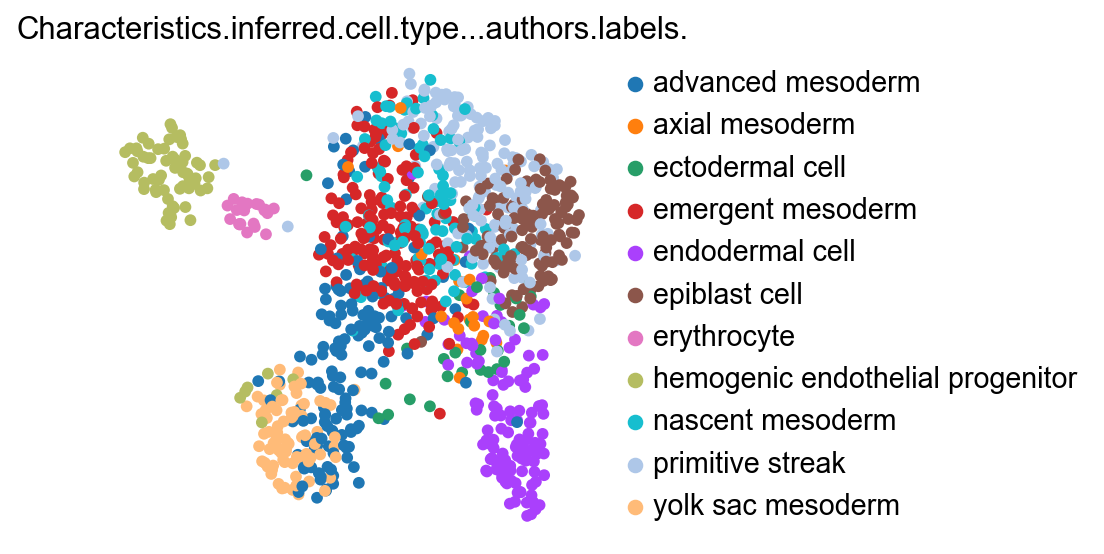

In [114]:
sc.pl.umap(adata, color=['Characteristics.inferred.cell.type...authors.labels.'], frameon=False)

In [115]:
hips.obs['batch'] = 'query'

In [116]:
hips.X = hips.X.astype(np.float32)


In [117]:
q_intr_cvae = sca.models.EXPIMAP.load_query_data(hips, intr_cvae)

Query data is missing expression data of  136  genes which were contained in the reference dataset.
The missing information will be filled with zeroes.
Query data contains expression data of  21702  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 4694 × 1977
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'run', 'sample_name', 'percent.mt', 'percent.dissoc', 'RNA_snn_res.0.3', 'seurat_clusters', 'RNA_snn_res.0.22', 'batch'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1977 256 2
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 224
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  224 0 0 2 1977
	with hard mask.
Last Decoder layer: softmax


In [118]:
q_intr_cvae.train(n_epochs=400, alpha_epoch_anneal=100, weight_decay=0., alpha_kl=0.1, seed=2020, use_early_stopping=True)


Preparing (4694, 1977)
Instantiating dataset
 |███████████---------| 59.8%  - val_loss: 1130.2525329590 - val_recon_loss: 1124.4212646484 - val_kl_loss: 58.3128881454
ADJUSTED LR
 |████████████--------| 61.5%  - val_loss: 1128.0008850098 - val_recon_loss: 1122.1711730957 - val_kl_loss: 58.2974691391
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 245


In [119]:
#q_intr_cvae.save('hippietippe_model')

In [120]:
dataset_samen = sc.AnnData.concatenate(adata, hips, batch_key='batch_join', uns_merge='same')
dataset_samen


AnnData object with n_obs × n_vars = 5763 × 1841
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Source.Name', 'Characteristics.sampling.site.', 'Characteristics.inferred.cell.type...authors.labels.', 'Characteristics.inferred.cell.type...ontology.labels.', 'cluster_id', 'sub_cluster', 'origin', 'run', 'sample_name', 'timepoint', 'percent.mt', 'batch', 'percent.dissoc', 'RNA_snn_res.0.3', 'seurat_clusters', 'RNA_snn_res.0.22', 'batch_join'
    var: 'features', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0'
    obsm: 'X_umap'

In [121]:
dataset_samen.X = dataset_samen.X.astype(np.float32)


In [122]:
model_genes = q_intr_cvae.adata.var_names
dataset_genes = dataset_samen.var_names
overlapping_genes = [gene for gene in dataset_genes if gene in model_genes]

print(f"Aantal genen in het model: {len(model_genes)}")
print(f"Aantal genen in dataset_samen: {len(dataset_genes)}")
print(f"Aantal overlappende genen: {len(overlapping_genes)}")


Aantal genen in het model: 1977
Aantal genen in dataset_samen: 1841
Aantal overlappende genen: 1841


In [123]:
print(f"Batch labels in dataset_samen: {dataset_samen.obs['batch'].unique()}")
print(f"Batch labels in het model: {q_intr_cvae.adata.obs['batch'].unique()}")


Batch labels in dataset_samen: ['reference' 'query']
Batch labels in het model: ['query']


In [124]:
dataset_samen.obsm['X_cvae'] = q_intr_cvae.get_latent(dataset_samen.X, dataset_samen.obs['batch'], mean=MEAN, only_active=True)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (512x1841 and 1977x256)

In [ ]:
sc.pp.neighbors(dataset_samen, use_rep='X_cvae')

In [ ]:
sc.tl.umap(dataset_samen)


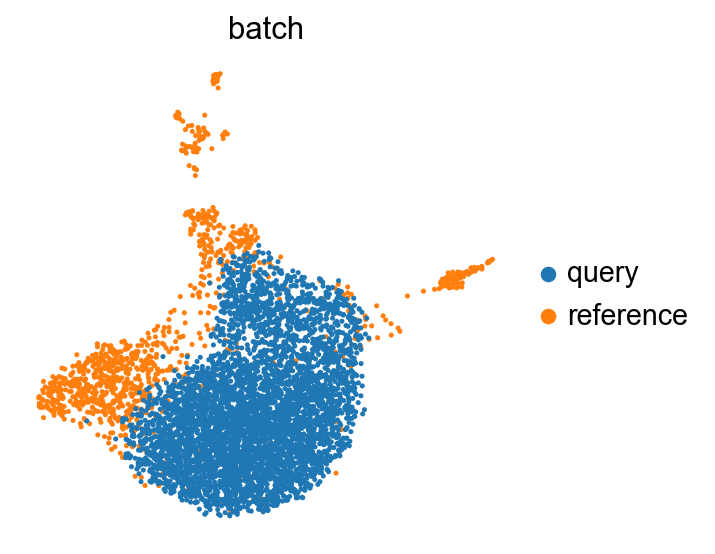

In [ ]:
sc.pl.umap(dataset_samen, color=['batch'], frameon=False, wspace=0.6)


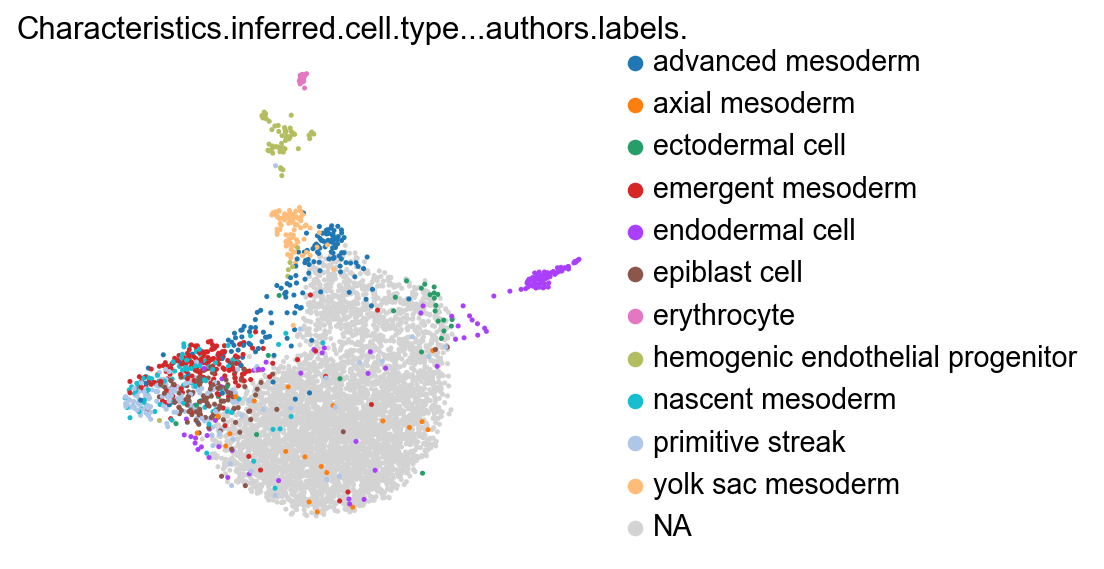

In [ ]:
sc.pl.umap(dataset_samen, color=['Characteristics.inferred.cell.type...authors.labels.'], frameon=False, wspace=0.6)

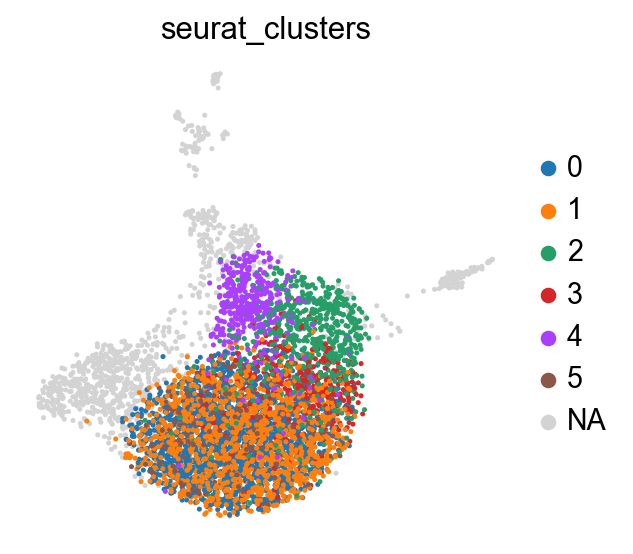

In [ ]:

sc.pl.umap(dataset_samen, color=['seurat_clusters'], frameon=False, wspace=0.6)

In [ ]:
dataset_samen.obs['orig.ident'] = dataset_samen.obs['orig.ident'].astype(str)


dataset_samen.write('../dataset/hipstyser_integrated.h5ad')